In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv("bank-additional-full.csv", ";")

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


В дескрипшене к датасету было указано, что столбец contact плохо влияет на модель - возникают риски переобучения, поэтому удалим этот столбец, а так же сделаем из y числовой, а не категориальный признак

In [4]:
df = df.drop('contact', axis=1)
df['y'].loc[df.y == 'no'] = 0
df['y'].loc[df.y == 'yes'] = 1
df = df.astype({'y': np.int})

In [5]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                   int32
dtype: object

In [6]:
df.head()

,age,job,marital,education,default,housing,loan,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


(array([36548.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4640.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

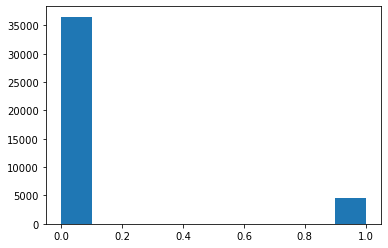

In [7]:
plt.hist(df['y'])

### Видно, что классы сильно несбалансированы
__Что с этим надо сделать?__: Лучше всего для наших предсказаний использовать правильную метрику - AUC RP, подходящую для несбалансированных классов.

Посмотрим, какие числовые признаки влияют на наш таргет и как: (но сначала разделим выборку на обучающую и тестовую, как и положено)

In [8]:
from sklearn.model_selection import train_test_split
X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=66, stratify=y)

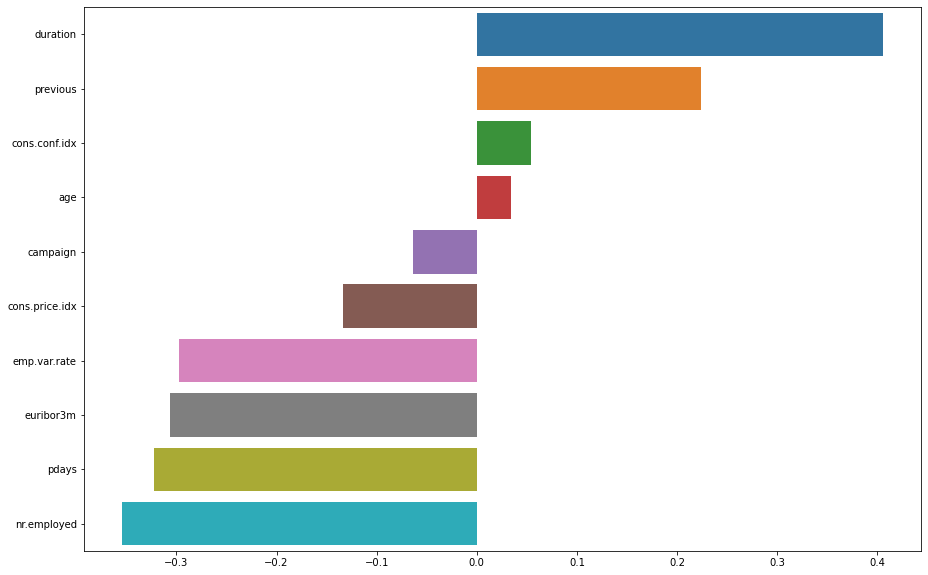

In [9]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Как видно на графике, корреляция Пирсона между числовыми признаками и y не очень велика - максимум что удалось достичь это 0.4. Логично предположить, что больше всего на ответы отвечают образование, текущая работа и семейный статус, а так же уже ищеющиеся кредиты.
Тогда давайте просто закодируем наши категориальные признаки(например, OneHotEncoder'ом), отмасштабируем числовые признаки и посмтрим на получившиеся веса нашей линейной модели(используем Logistic Regression:

In [10]:
categorical = df.dtypes[df.dtypes == 'object'].index.values
df_ohed = pd.get_dummies(df[categorical])

df = df.drop(columns=categorical)
df = df.join(df_ohed)
df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1), df['y'], test_size=0.2, 
                                                    random_state=66, stratify=df['y'])

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, plot_precision_recall_curve
log_res = LogisticRegression(max_iter=1000)
log_res.fit(X_train, y_train)
y_pred = log_res.predict(X_test)
auc_pr = average_precision_score(y_pred, y_test)
auc_pr

0.3040720440397072

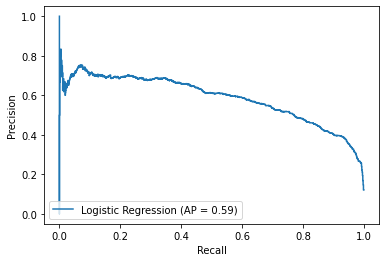

In [17]:
plot_precision_recall_curve(log_res, X_test, y_test, name = 'Logistic Regression')

__Посмотрим на 20 "сильнейших" признаков__:

In [19]:
our_dict = {}
for i in range(len(X_train.columns.values)):
    our_dict[X_train.columns.values[i]] = abs(log_res.coef_[0][i])
best_20 = [x[0] for x in sorted(our_dict.items(), key=lambda x: x[1])[-20:]]
best_20

['marital_married',
 'job_services',
 'education_basic.9y',
 'job_retired',
 'marital_single',
 'month_jun',
 'education_university.degree',
 'poutcome_nonexistent',
 'month_aug',
 'euribor3m',
 'default_unknown',
 'default_no',
 'poutcome_failure',
 'job_blue-collar',
 'month_jul',
 'previous',
 'month_mar',
 'cons.price.idx',
 'emp.var.rate',
 'month_may']

Как можно видеть, сильнее всего влияют статус отношений, работа и образование.